In [23]:
import torch as t
from tqdm import tqdm
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset, Subset
import numpy as np
import matplotlib.pyplot as plt
from modules import *

In [24]:
def get_dataset(train: bool = True) -> Dataset:
    img_size = 28
    transform = transforms.Compose([
        transforms.Resize(img_size),
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    dataset = datasets.MNIST(
        root = "/data",
        train = train,
        transform = transform,
        download = True,
    )

    return dataset

In [25]:
trainset_mnist = get_dataset()
train_num=int(1e4)
trainsubset_mnist=Subset(trainset_mnist,indices=np.random.choice(len(trainset_mnist),size=train_num))

plot_num=int(1e3)
plot_subset=Subset(trainsubset_mnist,indices=np.random.choice(len(trainsubset_mnist),size=plot_num))

In [26]:
batch_size=256
epochs=5
lr=1e-3

generative_model_latent_dim=2
generative_model_hidden_dim=128

sae_model_latent_dim=generative_model_latent_dim
sae_model_expansion_factor=16

In [27]:
generative_model_trainloader=DataLoader(trainsubset_mnist, batch_size=batch_size, shuffle=True)
sae_model_trainloader=DataLoader(trainsubset_mnist,batch_size=batch_size, shuffle=True)
plot_trainloader=DataLoader(plot_subset,batch_size=batch_size,shuffle=False)

In [28]:
generative_model=Autoencoder(generative_model_latent_dim,generative_model_hidden_dim)
sae_model=TiedWeightsAutoencoder(sae_model_latent_dim,sae_model_expansion_factor*sae_model_latent_dim)

generative_model_optimizer=t.optim.Adam(generative_model.parameters(),lr=lr)
sae_model_optimizer=t.optim.Adam(sae_model.parameters(),lr=lr)

In [29]:
generative_model.train()

step=0

progress_bar=tqdm(range(epochs))
for epoch in progress_bar:
    epoch_loss=0
    count=0
    for img, label in generative_model_trainloader:
        img_reconstructed = generative_model(img)[0]
        loss = nn.MSELoss()(img, img_reconstructed)
        loss.backward()
        generative_model_optimizer.step()
        generative_model_optimizer.zero_grad()
        step+=img.shape[0]
        epoch_loss+=loss*img.shape[0]
        count+=img.shape[0]
        progress_bar.set_description(f"epoch={epoch}, loss={epoch_loss/count:.4f}, examples_seen={step}")

epoch=4, loss=0.5597, examples_seen=50000: 100%|██████████| 5/5 [00:27<00:00,  5.60s/it]


  0%|          | 0/4 [00:00<?, ?it/s]

...plotting...: 100%|██████████| 4/4 [00:00<00:00,  9.33it/s]


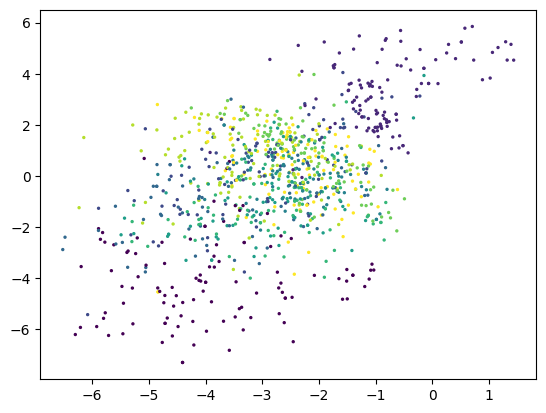

In [30]:
generative_model.eval()

fig,ax=plt.subplots(nrows=1,ncols=1)

progress_bar=tqdm(plot_trainloader,total=len(plot_trainloader))
for imgs,labels in progress_bar:
    progress_bar.set_description('...plotting...')
    latent_representations=generative_model(imgs)[1].detach().numpy()
    ax.scatter(latent_representations[:,0],latent_representations[:,1],c=labels,s=2)

In [31]:
generative_model.eval()
sae_model.train()

step = 0

progress_bar=tqdm(range(epochs))
for epoch in progress_bar:
    epoch_loss=0
    count=0
    for img, label in sae_model_trainloader:
        latent_representations=generative_model(img)[-1].detach()
        z_hat,c = sae_model(latent_representations)
        loss = TiedWeights_AutoencoderLoss((z_hat,c),latent_representations,alpha=1).mean()
        loss.backward()
        sae_model_optimizer.step()
        sae_model_optimizer.zero_grad()
        step+=img.shape[0]
        epoch_loss+=loss*img.shape[0]
        count+=len(label)
        progress_bar.set_description(f"epoch={epoch}, loss={epoch_loss/count:.4f}, examples_seen={step}")

epoch=4, loss=59.2713, examples_seen=50000: 100%|██████████| 5/5 [00:20<00:00,  4.16s/it] 


...plotting...: 100%|██████████| 4/4 [00:00<00:00,  7.69it/s]


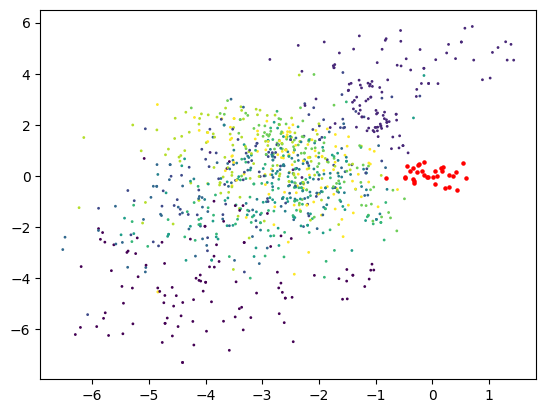

In [32]:
generative_model.eval()
sae_model.eval()

extracted_features=sae_model.weight

fig,ax=plt.subplots(nrows=1,ncols=1)

progress_bar=tqdm(plot_trainloader,total=len(plot_trainloader))
for imgs,labels in progress_bar:
    progress_bar.set_description('...plotting...')
    latent_representations=generative_model(imgs)[1].detach().numpy()
    ax.scatter(latent_representations[:,0],latent_representations[:,1],c=labels,s=1)

ax.scatter(extracted_features[:,0].detach().numpy(),extracted_features[:,1].detach().numpy(),c='red',s=5)

In [33]:
generative_model.eval()
sae_model.eval()

for i, (img,label) in enumerate(generative_model_trainloader):
    latent_representations=generative_model(img)[1]
    feature_activations=sae_model(latent_representations)[1]
    if i==0:
        feature_activations_trainset=feature_activations
    else:
        feature_activations_trainset=t.cat([feature_activations_trainset,feature_activations])

In [49]:
mean_feature_intensity=t.mean(feature_activations_trainset,axis=0).detach().numpy()

mean_feature_intensity_when_fired=np.zeros(feature_activations_trainset.shape[1])
sparsities=np.zeros(feature_activations_trainset.shape[1])
for k in range(feature_activations_trainset.shape[1]):
    feature_activations=feature_activations_trainset[:,k]
    mean_feature_intensity_when_fired[k]=t.mean(feature_activations[feature_activations>0]).item()
    sparsities[k]=(sum(feature_activations>0)/len(feature_activations)).item()

low_sparsity_features=np.argsort(sparsities)[:int(len(sparsities)*0.25)]
high_sparsity_features=np.argsort(sparsities)[-int(len(sparsities)*0.25):]

high_mean_features=np.argsort(mean_feature_intensity)[-int(len(mean_feature_intensity)*0.25)]

low_sparsity_high_mean_features=np.argsort(mean_feature_intensity[low_sparsity_features])[-min(5,len(low_sparsity_features)):]
high_sparsity_high_mean_features=np.argsort(mean_feature_intensity[high_sparsity_features])[-min(5,len(high_sparsity_features)):]

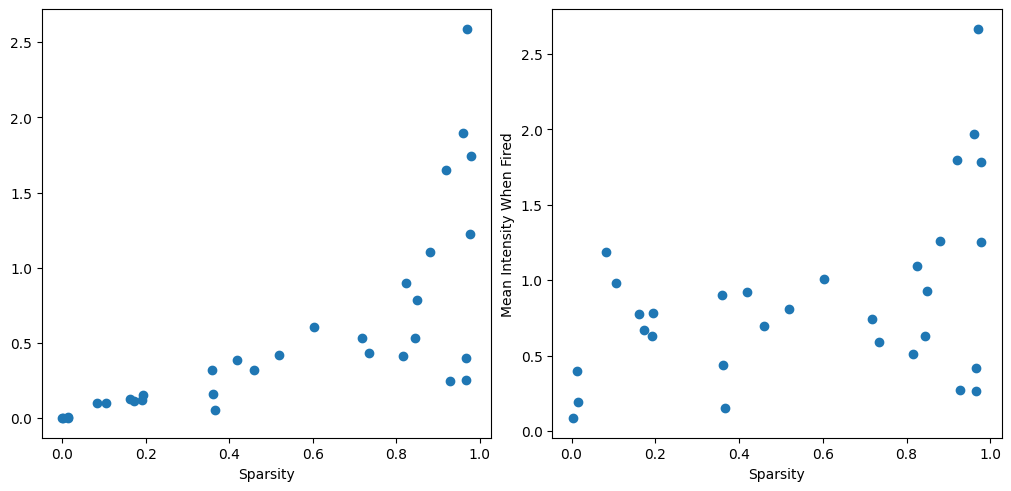

In [50]:
fig,axs=plt.subplots(nrows=1,ncols=2,layout='constrained')
fig.set_figwidth(10)

axs[0].scatter(sparsities,mean_feature_intensity)
axs[0].set_xlabel('Sparsity')
axs[1].set_ylabel('Mean Intensity')
axs[1].scatter(sparsities,mean_feature_intensity_when_fired)
axs[1].set_xlabel('Sparsity')
axs[1].set_ylabel('Mean Intensity When Fired')

plt.show()